# deep convolution network

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from data.mnist import load_mnist
import matplotlib.pyplot as plt
from common import optimizer

class DeepConvNet:
    '''
    認識率99%以上の高精度なConvNet

    conv - relu - conv- relu - pool -
    conv - relu - conv- relu - pool -
    conv - relu - conv- relu - pool -
    affine - relu - dropout - affine - dropout - softmax
    '''
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 重みの初期化===========
        # 各層のニューロンひとつあたりが、前層のニューロンといくつのつながりがあるか
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # Heの初期値
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(pre_node_nums[6], hidden_size)
        print(self.params['W7'].shape)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(pre_node_nums[7], output_size)
        self.params['b8'] = np.zeros(output_size)

        # レイヤの生成===========
        self.layers = []
        self.layers.append(layers.Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(layers.Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(layers.Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(layers.Affine(self.params['W7'], self.params['b7']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Dropout(0.5))
        self.layers.append(layers.Affine(self.params['W8'], self.params['b8']))
        self.layers.append(layers.Dropout(0.5))
        
        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, layers.Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, d):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td)

        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

データ読み込み完了
(1024, 50)
Generation: 10. 正答率(トレーニング) = 0.295
                : 10. 正答率(テスト) = 0.282
Generation: 20. 正答率(トレーニング) = 0.521
                : 20. 正答率(テスト) = 0.507
Generation: 30. 正答率(トレーニング) = 0.6846
                : 30. 正答率(テスト) = 0.653
Generation: 40. 正答率(トレーニング) = 0.7258
                : 40. 正答率(テスト) = 0.696
Generation: 50. 正答率(トレーニング) = 0.7926
                : 50. 正答率(テスト) = 0.788
Generation: 60. 正答率(トレーニング) = 0.8538
                : 60. 正答率(テスト) = 0.831
Generation: 70. 正答率(トレーニング) = 0.8684
                : 70. 正答率(テスト) = 0.832
Generation: 80. 正答率(トレーニング) = 0.91
                : 80. 正答率(テスト) = 0.881
Generation: 90. 正答率(トレーニング) = 0.9104
                : 90. 正答率(テスト) = 0.884
Generation: 100. 正答率(トレーニング) = 0.9388
                : 100. 正答率(テスト) = 0.922


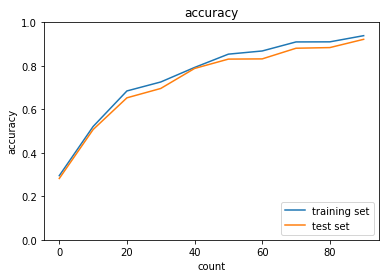

In [2]:
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]

print("データ読み込み完了")

network = DeepConvNet()  
optimizer = optimizer.Adam()

iters_num = 100
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

層が深い分、学習に非常に時間がかかる  
ただやはり正答率は高い